In [1]:
"""LOAD DATA"""

import cftime
from datetime import timedelta 
import xarray as xr

YEARS = [2000, 2001, 2002, 2003, 2004]
zarr_path = f"/home/tsternal/WeatherExtremes/data/michaels_t2_single_arr_mean_zarr_{min(YEARS)}_2005.zarr"
var = "daily_mean_2m_temperature"

daily_mean_2m_temperature = xr.open_zarr(zarr_path)[var]
daily_mean_2m_temperature = daily_mean_2m_temperature.convert_calendar('noleap')

def get_gridpoint(ds, lat, lon):
    return ds.sel(lat=slice(lat, lat+0.1), lon=slice(lon, lon+0.1))

gp = get_gridpoint(daily_mean_2m_temperature, 0, 0)
gp


<xarray.DataArray 'daily_mean_2m_temperature' (time: 2251, lat: 1, lon: 1)> Size: 9kB
dask.array<getitem, shape=(2251, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 8B 0.0
  * lon      (lon) float64 8B 0.0
  * time     (time) object 18kB 1999-11-01 00:00:00 ... 2005-12-31 00:00:00

In [20]:
"""PLOT RAW DATA"""

import matplotlib.pyplot as plt
import xarray as xr

def plot_yearly_values(da, years, new_fig=True):
    """
    Plots the values of a xarray.DataArray for each year in the provided list.

    Parameters:
    - dataarray (xr.DataArray): A DataArray with dimensions lat, lon, and time.
    - years (list of int): List of years to plot.
    """
    
    if "time" not in da.dims:
        raise ValueError("DataArray must have a 'time' dimension.")

    time_dim = da.coords['time']

    if new_fig:
        plt.figure(figsize=(10, 6))

    for year in years:
        # Filter for the specific year
        yearly_data = da.sel(time=str(year))
        if yearly_data.time.size == 0:
            print(f"No data available for the year {year}")
            continue
        
        # Convert time to day-of-year
        day_of_year = yearly_data.time.dt.dayofyear

        # Plot the values
        plt.plot(day_of_year.values, yearly_data.values, label=str(year), linewidth=1)

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Yearly values")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    
plot_yearly_values(gp.sel(lat=0, lon=0), YEARS)

Converting to no-leap calendar
Calculating Aggregations...
<xarray.DataArray 'daily_mean_2m_temperature' (time: 1843, lat: 1, lon: 1)> Size: 7kB
dask.array<truediv, shape=(1843, 1, 1), dtype=float32, chunksize=(5, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 8B 0.0
  * lon      (lon) float64 8B 0.0
  * time     (time) object 15kB 1999-12-23 00:00:00 ... 2005-01-09 00:00:00


<module 'matplotlib.pyplot' from '/home/tsternal/WeatherExtremes/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

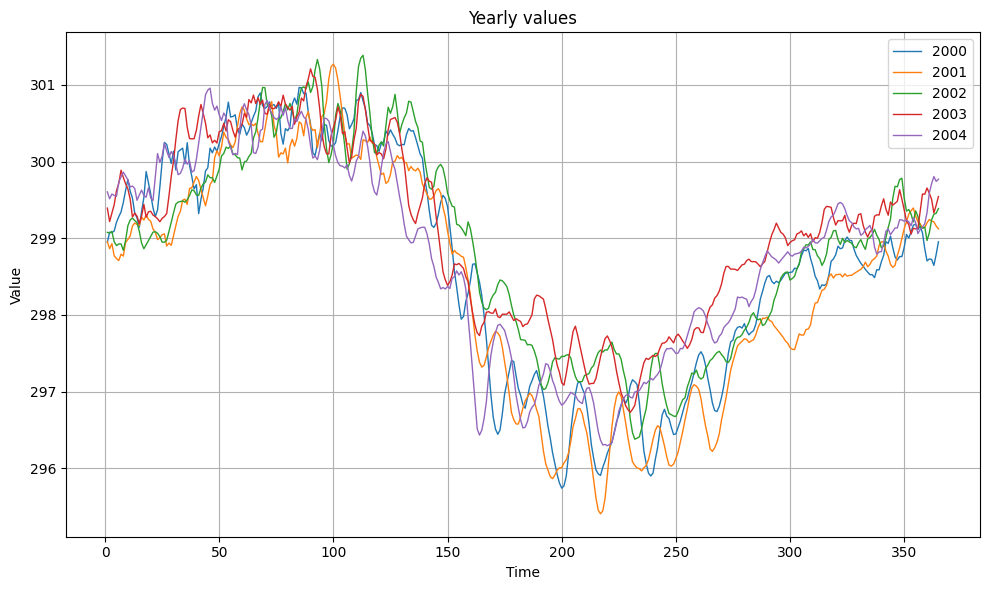

In [13]:
"""PLOT AGGREGATED DATA"""
from optimised_solution.optimised import aggregate
from enums import AGG

AGG_WINDOW = 5
PERC_BOOST_WINDOW = 15
start_year = min(YEARS)
end_year = max(YEARS)

timedif = timedelta(days = AGG_WINDOW // 2 + PERC_BOOST_WINDOW //2)

agg_start = cftime.DatetimeNoLeap(start_year, 1, 1) - timedif # Must be 1st Jan
agg_end = cftime.DatetimeNoLeap(end_year, 12, 31) + timedif # Must be 31st Dec

# ds = gp.sel(lat=0, lon=0)
# ds = aggregate(ds, AGG.MEAN, AGG_WINDOW, agg_start, agg_end)

ds = aggregate(gp, AGG.MEAN, AGG_WINDOW, agg_start, agg_end)
print(ds)
plot_yearly_values(ds.sel(lat=0, lon=0), YEARS)

In [14]:
# """NAIVE PERCENTILES CALCUATION """

# import numpy as np

# def calculate_percentiles(da, doys, perc_boost_window, percentile):
#     delta = perc_boost_window // 2

#     # Group by DOY
#     grouped = da.groupby(da.time.dt.dayofyear)
#     for i, group in enumerate(grouped):
#         print(group)
#     groups = {i: group.values for i, group in enumerate(grouped)}

#     percentiles = [0 for i in range(365)]
#     for doy in doys:
#         start = doy - delta
#         end = doy + delta
                
#         values = [groups[i].values.flatten() for i in range(start, end+1)]
#         print(values)
#         values = np.concat(values)
#         print(doy, values.shape)
#         percentile = np.percentile(values, percentile)
#         print(doy, percentile)
#         percentiles[doy] = percentile
#     return percentiles

In [15]:
"""CALCULATE PRE-PERCENTILE ZARR"""
from optimised_solution.optimised import parallel_pre_percentile_arrange, save_pre_percentile_to_zarr

n_years = len(YEARS)
doy = list(range(1, 366))
# percentiles = calculate_percentiles(ds, doys, perc_boost_window, percentile)

perc_start = cftime.DatetimeNoLeap(start_year, 1, 1)
perc_end = cftime.DatetimeNoLeap(end_year, 12, 31)

pre_perc_zarr_path = 'pre_percentile.zarr'
pre_percentile_ds = parallel_pre_percentile_arrange(ds, n_years,  perc_start, perc_end, PERC_BOOST_WINDOW)

save_pre_percentile_to_zarr(pre_percentile_ds, pre_perc_zarr_path, n_years)
print(ds)


Rearranging data into pre-percentile format


100%|██████████| 379/379 [00:58<00:00,  6.49it/s]

Rearranging: 58.35681676864624 seconds
<xarray.DataArray 'daily_mean_2m_temperature' (time: 1843, lat: 1, lon: 1)> Size: 7kB
dask.array<truediv, shape=(1843, 1, 1), dtype=float32, chunksize=(5, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 8B 0.0
  * lon      (lon) float64 8B 0.0
  * time     (time) object 15kB 1999-12-23 00:00:00 ... 2005-01-09 00:00:00


In [16]:
"""CALCULATE PERCENTILES"""
import zarr
from optimised_solution.optimised import calculate_percentile

PERC = 0.95
pre_perc_zarr = zarr.open(pre_perc_zarr_path)
percentiles = calculate_percentile(PERC_BOOST_WINDOW, n_years, pre_perc_zarr, PERC, lat_size=1, lon_size=1)

BAND_SIZE 1


100%|██████████| 1/1 [00:00<00:00, 30.41it/s]

Percentiles Band Shape (365, 1, 1)


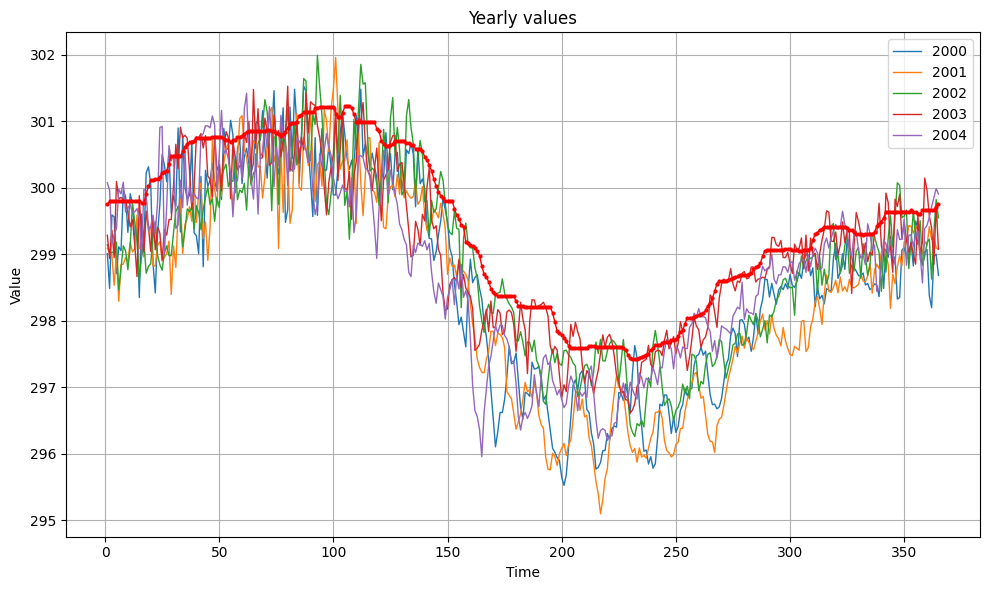

In [17]:
"""PLOT RAW DATA AND PERCENTILES"""
gp = get_gridpoint(daily_mean_2m_temperature, 0, 0)
plot_yearly_values(gp.sel(lat=0, lon=0), YEARS)
plt.plot(range(1, percentiles.shape[0]+1), percentiles[:,0,0], 'ro-', markersize=1, linewidth=1)


Converting to no-leap calendar
Calculating Aggregations...


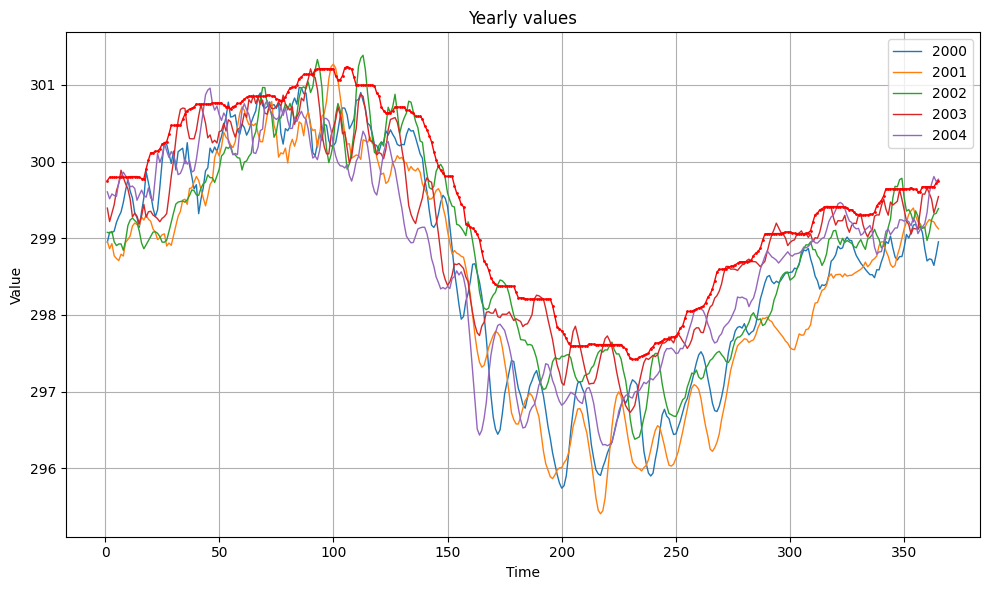

In [18]:
start_year = min(YEARS)
end_year = max(YEARS)

timedif = timedelta(days = AGG_WINDOW // 2 + PERC_BOOST_WINDOW //2)

agg_start = cftime.DatetimeNoLeap(start_year, 1, 1) - timedif # Must be 1st Jan
agg_end = cftime.DatetimeNoLeap(end_year, 12, 31) + timedif # Must be 31st Dec

ds = gp.sel(lat=0, lon=0)
ds = aggregate(ds, AGG.MEAN, AGG_WINDOW, agg_start, agg_end)

plot_yearly_values(ds, YEARS)
plt.plot(range(1, percentiles.shape[0]+1), percentiles[:,0,0], 'ro-', markersize=1, linewidth=1)

Converting to no-leap calendar
Calculating Aggregations...


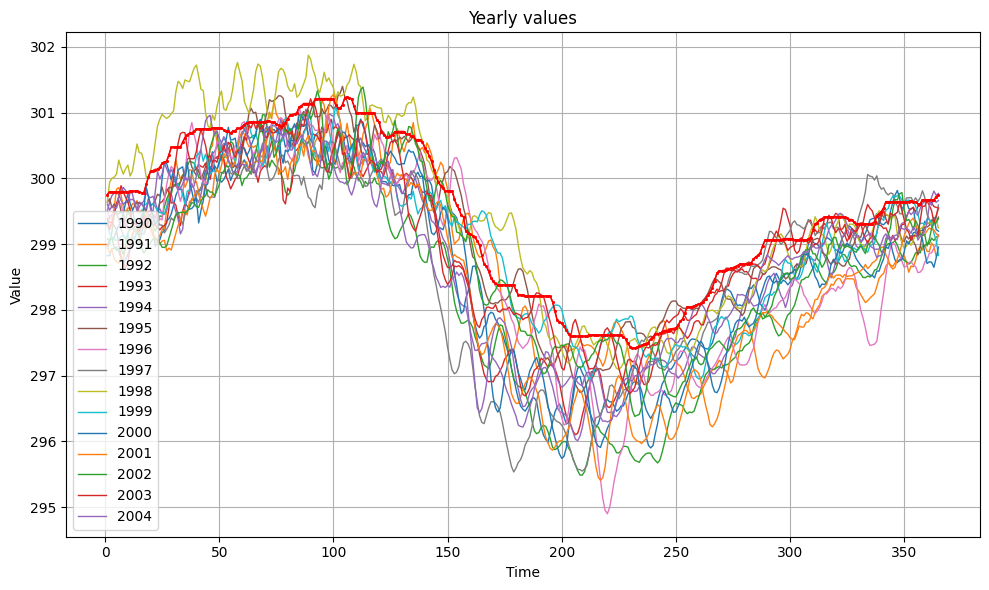

In [24]:
import cftime
from datetime import timedelta 
import xarray as xr

YEARS = list(range(1990, 2005))
zarr_path = f"/home/tsternal/WeatherExtremes/data/michaels_t2_single_arr_mean_zarr_{min(YEARS)}_2006.zarr"
var = "daily_mean_2m_temperature"

daily_mean_2m_temperature = xr.open_zarr(zarr_path)[var]
daily_mean_2m_temperature = daily_mean_2m_temperature.convert_calendar('noleap')

def get_gridpoint(ds, lat, lon):
    return ds.sel(lat=slice(lat, lat+0.1), lon=slice(lon, lon+0.1))

gp = get_gridpoint(daily_mean_2m_temperature, 0, 0)
# plot_yearly_values(gp.sel(lat=0, lon=0), YEARS, new_fig=False)


start_year = min(YEARS)
end_year = max(YEARS)

timedif = timedelta(days = AGG_WINDOW // 2 + PERC_BOOST_WINDOW //2)

agg_start = cftime.DatetimeNoLeap(start_year, 1, 1) - timedif # Must be 1st Jan
agg_end = cftime.DatetimeNoLeap(end_year, 12, 31) + timedif # Must be 31st Dec

ds = gp.sel(lat=0, lon=0)
ds = aggregate(ds, AGG.MEAN, AGG_WINDOW, agg_start, agg_end)

plot_yearly_values(ds, YEARS)
plt.plot(range(1, percentiles.shape[0]+1), percentiles[:,0,0], 'ro-', markersize=1, linewidth=1)



plt.plot(range(1, percentiles.shape[0]+1), percentiles[:,0,0], 'ro-', markersize=1, linewidth=1)

In [1]:
import numpy as np
a = np.load('/home/tsternal/WeatherExtremes/daily_mean_2m_temperature_1990_1994_AGG.MEAN_aggrwindow_5_percboost_5/percentiles_0_95.npy')
print(a.shape)

(365, 721, 1440)
